## Capstone Project

### Firstly importing the all the required libraries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
from bs4 import BeautifulSoup

### Now Using BeautifulSoup to convert wiki file to XML

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_populated_places_in_New_Mexico'
html = requests.get(wiki_url).text
soup = BeautifulSoup(html, 'lxml')
print(soup)

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of populated places in New Mexico - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XivyOQpAAEIAAASu8IMAAABY","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_populated_places_in_New_Mexico","wgTitle":"List of populated places in New Mexico","wgCurRevisionId":916835285,"wgRevisionId":916835285,"wgArticleId":581105,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Lists of c

In [4]:
my_table = soup.find('table', {'class' : 'wikitable sortable'})
print(my_table)

<table border="1" class="wikitable sortable" width="480">
<tbody><tr>
<th>Place
</th>
<th>Population
</th>
<th>County
</th>
<th>Category
</th></tr>
<tr>
<td><a href="/wiki/Albuquerque,_New_Mexico" title="Albuquerque, New Mexico">Albuquerque</a>
</td>
<td align="right">545,852
</td>
<td align="right"><a href="/wiki/Bernalillo_County,_New_Mexico" title="Bernalillo County, New Mexico">Bernalillo</a>
</td>
<td align="right">City
</td></tr>
<tr>
<td><a href="/wiki/Las_Cruces,_New_Mexico" title="Las Cruces, New Mexico">Las Cruces</a>
</td>
<td align="right">97,618
</td>
<td align="right"><a href="/wiki/Do%C3%B1a_Ana_County,_New_Mexico" title="Doña Ana County, New Mexico">Doña Ana</a>
</td>
<td align="right">City
</td></tr>
<tr>
<td><a href="/wiki/Rio_Rancho,_New_Mexico" title="Rio Rancho, New Mexico">Rio Rancho</a>
</td>
<td align="right">87,521
</td>
<td align="right"><a href="/wiki/Sandoval_County,_New_Mexico" title="Sandoval County, New Mexico">Sandoval</a><br/><a href="/wiki/Bernalillo_C

In [4]:
# Rank = []
City = []
Estimate = []
Region = []
for row in my_table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 4:
#         Rank.append(cells[0].find(text = True))
        City.append(cells[0].find(text = True))
        Estimate.append(cells[1].find(text = True))
        Region.append(cells[2].find(text = True))


for i in Estimate:
    j = i.strip()
    Estimate[Estimate.index(i)] = j
for i in Estimate:
    i = str(i)
    j = i.replace(',', '')
    Estimate[Estimate.index(i)] = int(j)

#### Converting data into dataframe

In [5]:
Mexico_df = pd.DataFrame({ 'City': City, 'Region' : Region,'Estimate' : Estimate})

Mexico_df = Mexico_df.drop([ 'Region'], axis = 1)

Mexico_df = Mexico_df[Mexico_df.Estimate > 13000]

In [6]:
Mexico_df

,City,Estimate
0,Albuquerque,545852
1,Las Cruces,97618
2,Rio Rancho,87521
3,Santa Fe,67947
4,Roswell,48366
5,Farmington,45877
6,South Valley,40976
7,Clovis,37775
8,Hobbs,34122
9,Alamogordo,30403


#### Obtaining longitude and latitude using geolocator 

In [7]:
Latitude = []
Longitude = []

for i in Mexico_df.City:
    address = i + ', New Mexico'
    geolocator = Nominatim(user_agent = 'my-application')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(latitude)
    Longitude.append(longitude)
    
Mexico_df['Latitude'] = Latitude
Mexico_df['Longitude'] = Longitude

In [8]:
Mexico_df

,City,Estimate,Latitude,Longitude
0,Albuquerque,545852,35.084103,-106.650985
1,Las Cruces,97618,32.314035,-106.779808
2,Rio Rancho,87521,35.269381,-106.632819
3,Santa Fe,67947,35.687000,-105.937800
4,Roswell,48366,33.394328,-104.522952
5,Farmington,45877,36.729115,-108.205445
6,South Valley,40976,35.015420,-106.677842
7,Clovis,37775,34.405472,-103.205071
8,Hobbs,34122,32.707667,-103.131131
9,Alamogordo,30403,32.904647,-105.941835


#### Marking these cordinates on map

In [9]:
map_Mexico = folium.Map(location=[34.307144,  -106.018066], zoom_start = 6)

for lat, lng, city in zip(Mexico_df['Latitude'], Mexico_df['Longitude'], Mexico_df['City']):
    label = '{}, New Mexico'.format(city)
    label = folium.Popup(label, parse_html = True)
    folium.Circle(
        [lat, lng],
        radius = 2000,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(map_Mexico)

map_Mexico

#### Now gathering information for venues around these coordinates using foursquare API

In [10]:
CLIENT_ID = 'D3C14N1OU333QZCIEF14KENVD4ROJAMVH1VAWDIPDOZL0KXM'
CLIENT_SECRET = 'CA43PLBBUV2RB3HNBRM1TFXWRGAUSQSPQXWAVSSPLSXGO2GI'
VERSION = '20180605'


def getNearbyVenues(names, latitudes, longitudes, radius = 2000, LIMIT = 33):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()['response']
        for v in results['venues'] :
            venues_list.append([(name,
                                 lat,
                                 lng,
                                 v['name'],
                                 v['id'],
                                 v['location']['lat'],
                                 v['location']['lng'], 
                                 v['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             'City Latitude',
                             'City Longitude', 
                             'Venue',
                             'Venue Id',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Mexico_venues = getNearbyVenues(names = Mexico_df['City'],
                                 latitudes = Mexico_df['Latitude'],
                                 longitudes = Mexico_df['Longitude'])

Albuquerque
Las Cruces
Rio Rancho
Santa Fe
Roswell
Farmington
South Valley
Clovis
Hobbs
Alamogordo
Carlsbad
Gallup
Deming
Los Lunas
Chaparral
Sunland Park
Las Vegas


In [11]:
Mexico_venues.shape

(448, 8)

In [12]:
Mexico_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Albuquerque,35.084103,-106.650985,Brixens,56eb6267498e27e292fa0d8b,35.084528,-106.651705,Gastropub
1,Albuquerque,35.084103,-106.650985,Sister Bar,5042e0ebe4b0152f584c9218,35.084789,-106.651973,Bar
2,Albuquerque,35.084103,-106.650985,Humble Coffee Company,59a1a08cea1e4455c4532921,35.084846,-106.652954,Coffee Shop
3,Albuquerque,35.084103,-106.650985,The Roastery,59eba8422632ec468f349391,35.088487,-106.645517,Coffee Shop
4,Albuquerque,35.084103,-106.650985,Tucanos Brazilian Grill,4b761755f964a520133c2ee3,35.084143,-106.648454,Brazilian Restaurant


#### Gathering information of Price and Rating using foursquare

In [ ]:
CLIENT_ID = 'WFU4QVT5P2VFOGGHWIT1N2IFDKK15VR2LNBUXTH4GJ1JSMBQ'
CLIENT_SECRET = 'E5HD1RAH4PVBJ403KLILAI0BU4MY0ZMRYEBRKR0EIBBZBGVE'
VERSION = '20180605'

def PriceandRating (v_id):
    ratings_list=[]
    j=0
    for i in v_id:
        venue_id = str(i)
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        results = requests.get(url).json()['response']
        try:
            ratings_list.append([(i,
                                  results['venue']['rating'],
                                  results['venue']['price']['tier'])])
        except:
            ratings_list.append([(i,
                                  'Rating or Tier not present',
                                  'Rating or Tier not present')])
            j+=1
        
    rating_venues = pd.DataFrame([item for ratings_list in ratings_list for item in ratings_list])
    rating_venues.columns = ['Venue Id',
                             'Venue Rating', 
                             'Venue Price']
    
    return(rating_venues, j)

Venue_ratings,error = PriceandRating(Mexico_venues["Venue Id"])
print(error)

In [ ]:
Venue_ratings.shape

In [65]:
Venue_ratings.head()

,Venue Id,Venue Rating,Venue Price
0,5042e0ebe4b0152f584c9218,8.2,2
1,5bc28bfa6bdee6002cea174c,Rating or Tier not present,Rating or Tier not present
2,56eb6267498e27e292fa0d8b,7.3,3
3,59a1a08cea1e4455c4532921,Rating or Tier not present,Rating or Tier not present
4,4bf335206a31d13a4370942e,7.5,1


In [66]:
Venue_ratings[Venue_ratings['Venue Rating'] != 'Rating or Tier not present'].shape

(330, 3)

In [68]:
Venue_ratings_2 = Venue_ratings.set_index('Venue Id')
Mexico_venues_2 = Mexico_venues.set_index('Venue Id')

Mexico_venues_data = Mexico_venues_2.join(Venue_ratings_2)
Mexico_venues_data = Mexico_venues_data[Mexico_venues_data['Venue Rating'] != 'Rating or Tier not present']
Mexico_venues_data = Mexico_venues_data.reset_index(drop = True)

In [69]:
Mexico_venues_data.shape

(330, 9)

In [135]:
Mexico_venues_data

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Rating,Venue Price
0,Albuquerque,35.084103,-106.650985,Sister Bar,35.084789,-106.651973,Bar,8.2,2
1,Albuquerque,35.084103,-106.650985,Brixens,35.084528,-106.651705,Gastropub,7.3,3
2,Albuquerque,35.084103,-106.650985,JC's New York Pizza Department,35.084285,-106.649676,Pizza Place,7.5,1
3,Albuquerque,35.084103,-106.650985,MÁS Tapas y Vino,35.085096,-106.649272,Restaurant,6.8,2
4,Albuquerque,35.084103,-106.650985,Espresso Fino,35.083386,-106.650353,Coffee Shop,8.6,1
5,Albuquerque,35.084103,-106.650985,Starbucks,35.086530,-106.650343,Coffee Shop,6.2,1
6,Albuquerque,35.084103,-106.650985,Tucanos Brazilian Grill,35.084143,-106.648454,Brazilian Restaurant,7.9,2
7,Albuquerque,35.084103,-106.650985,Forque - Kitchen & Bar,35.086572,-106.650970,New American Restaurant,6.7,1
8,Albuquerque,35.084103,-106.650985,Church Street Cafe,35.097301,-106.669990,Mexican Restaurant,8,2
9,Albuquerque,35.084103,-106.650985,zendo,35.080694,-106.650050,Café,8.8,2


#### Now marking venue locations on map

In [71]:
map_venues = folium.Map(location=[34.307144,  -106.018066], zoom_start = 6)

for lat, lng, venue, cat in zip(Mexico_venues_data['Venue Latitude'],
                                Mexico_venues_data['Venue Longitude'],
                                Mexico_venues_data['Venue'],
                                Mexico_venues_data['Venue Category']):
    label = '{}, {}'.format(venue, cat)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [lat, lng],
        popup = label).add_to(map_venues)

map_venues

In [72]:
Mexico_venues_data_2 = pd.get_dummies(Mexico_venues_data, columns=['Venue Category', 'City'])
Mexico_venues_data_2.head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Rating,Venue Price,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_BBQ Joint,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bar,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Coffee Shop,Venue Category_Deli / Bodega,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Fast Food Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Gastropub,Venue Category_Hot Dog Joint,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Mexican Restaurant,Venue Category_New American Restaurant,Venue Category_Pizza Place,Venue Category_Restaurant,Venue Category_Salad Place,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Taco Place,Venue Category_Tapas Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Thai Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Wings Joint,City_Alamogordo,City_Albuquerque,City_Carlsbad,City_Clovis,City_Deming,City_Farmington,City_Gallup,City_Hobbs,City_Las Cruces,City_Las Vegas,City_Los Lunas,City_Rio Rancho,City_Roswell,City_Santa Fe,City_South Valley,City_Sunland Park
0,35.084103,-106.650985,Sister Bar,35.084789,-106.651973,8.2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,35.084103,-106.650985,Brixens,35.084528,-106.651705,7.3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35.084103,-106.650985,JC's New York Pizza Department,35.084285,-106.649676,7.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,35.084103,-106.650985,MÁS Tapas y Vino,35.085096,-106.649272,6.8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.084103,-106.650985,Espresso Fino,35.083386,-106.650353,8.6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
Venues_dataset_2 = Mexico_venues_data_2.drop(['Venue', 'City Latitude', 'City Longitude'], axis = 1)
Venues_dataset_2.columns.name = Venues_dataset_2.index.name
Venues_dataset_2.index.name = None

In [74]:
Venues_dataset_2.to_csv('Venues_Mexico.csv')
Venues_dataset_2.head()

,Venue Latitude,Venue Longitude,Venue Rating,Venue Price,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_BBQ Joint,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bar,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Café,Venue Category_Chinese Restaurant,Venue Category_Coffee Shop,Venue Category_Deli / Bodega,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Fast Food Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Gastropub,Venue Category_Hot Dog Joint,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Italian Restaurant,Venue Category_Japanese Restaurant,Venue Category_Mexican Restaurant,Venue Category_New American Restaurant,Venue Category_Pizza Place,Venue Category_Restaurant,Venue Category_Salad Place,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Taco Place,Venue Category_Tapas Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Thai Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Wings Joint,City_Alamogordo,City_Albuquerque,City_Carlsbad,City_Clovis,City_Deming,City_Farmington,City_Gallup,City_Hobbs,City_Las Cruces,City_Las Vegas,City_Los Lunas,City_Rio Rancho,City_Roswell,City_Santa Fe,City_South Valley,City_Sunland Park
0,35.084789,-106.651973,8.2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,35.084528,-106.651705,7.3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35.084285,-106.649676,7.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,35.085096,-106.649272,6.8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.083386,-106.650353,8.6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Now importing required material for KNN

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [76]:
Venues_df = Venues_dataset_2.drop(['Venue Latitude', 'Venue Longitude'], axis = 1)
Price_check = Venues_df.groupby(['Venue Price']).count()
Price_check['Venue Rating']

Venue Price
1    247
2     68
3      9
4      6
Name: Venue Rating, dtype: int64

In [77]:
Venues_df = Venues_df[Venues_df['Venue Price'] != 4]
data = Venues_df.drop(['Venue Price'], axis = 1)
target = Venues_df['Venue Price']

#### Spliting the data into train and test

In [78]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 0)

In [79]:
neighbors = list(range(1,40, 2))

cv_scores_1 = []

y_train = y_train.astype('int')
y_test = y_test.astype('int')

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    jac = jaccard_similarity_score(y_test, pred)
    cv_scores_1.append(jac)

The optimal number of neighbors is 1


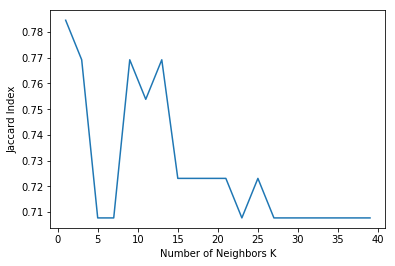

In [80]:
optimal_k_1 = neighbors[cv_scores_1.index(max(cv_scores_1))]
print('The optimal number of neighbors is %d' % optimal_k_1)

plt.plot(neighbors, cv_scores_1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Jaccard Index')
plt.show()

#### As our data is very small because of constrain in foursquare API we are getting k =1.
#### Lets use some another method for obtaining k.

In [85]:
cv_scores_2 = []

for k in neighbors:
    if (k < 40) :
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores_2.append(scores.mean())

C:\Users\RAJESH\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\RAJESH\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\RAJESH\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\RAJESH\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few.

The optimal number of neighbors is 27


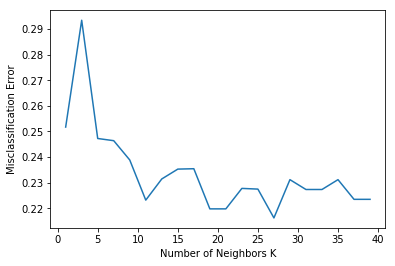

In [86]:
MSE = [1 - x for x in cv_scores_2]

optimal_k_2 = neighbors[MSE.index(min(MSE))]
print('The optimal number of neighbors is %d' % optimal_k_2)

plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### Now we can se we are getting k=27 which is too large.
#### So as we are not getting optimistic values let start analysing on different basis.
#### Lets make a hist between Price and Ratings

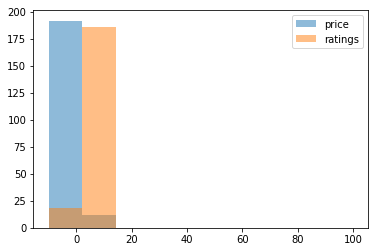

In [165]:
import numpy
from matplotlib import pyplot as plt
bins = numpy.linspace(-10, 100, 10)
pyplot.hist(l, bins, alpha=0.5, label='price')
pyplot.hist(j, bins, alpha=0.5, label='ratings')
pyplot.legend(loc='upper right')
pyplot.show()

*** As from this Histogram we can Directly say that lesser the price better the ratings ***

In [158]:
x.append(Mexico_venues_data.loc[315:329,"Venue Rating"].mean())

In [160]:
x.insert(14,0)

#### Given above is the list of average rating of restaurants.
#### Given below is the list of population of cities.

In [168]:
y=[]
for i in range(17):
        y.append(Mexico_df["Estimate"][i])
print(y)

[545852, 97618, 87521, 67947, 48366, 45877, 40976, 37775, 34122, 30403, 26138, 21678, 14855, 14835, 14631, 14106, 13753]


#### Lets make a Scatter plot Between Population and rating.

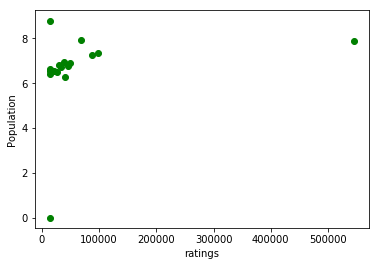

In [176]:
plt.scatter(y,x,c="green")
plt.xlabel("ratings")
plt.ylabel("Population")
plt.show()

*** As we can say that the polpulation factor is not dependent on ratings as the points are random ***

#### Using methematical fun max obtaining maximum ratings and the city associated with it.

In [192]:
m=max(x)
t=x.index(m)
print(Mexico_df["City"][t], "Average value= ",m)

Sunland Park Average value=  8.8


*** Sunland Park is the best cith with average rating = 8.8 ***

#### Lets obtain then most popular areas in Sunland Park

In [7]:
CLIENT_ID = 'D3C14N1OU333QZCIEF14KENVD4ROJAMVH1VAWDIPDOZL0KXM'
CLIENT_SECRET = 'CA43PLBBUV2RB3HNBRM1TFXWRGAUSQSPQXWAVSSPLSXGO2GI'
VERSION = '20180605'
radius=2000
LIMIT=50
latitude=31.796496
longitude=-106.579989
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=D3C14N1OU333QZCIEF14KENVD4ROJAMVH1VAWDIPDOZL0KXM&client_secret=CA43PLBBUV2RB3HNBRM1TFXWRGAUSQSPQXWAVSSPLSXGO2GI&ll=31.796496,-106.579989&v=20180605&radius=2000&limit=50'

In [8]:
import requests

In [9]:
results = requests.get(url).json()
'There are {} in Sunland Park.'.format(len(results['response']['groups'][0]['items']))

'There are 7 in Sunland Park.'

In [10]:
items = results['response']['groups'][0]['items']


In [14]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,isFuzzed,isServiceAreaBusiness,labeledLatLngs,lat,lng,postalCode,state,id
0,Family Dollar,Discount Store,1673 McNutt Rd,US,Sunland Park,United States,NaN,957,"[1673 McNutt Rd, Sunland Park, NM 88063, Unite...",NaN,NaN,"[{'label': 'display', 'lat': 31.79603679843494...",31.796037,-106.569885,88063,NM,4e344eca7d8b0c62b2c81cad
1,Western Playland,Theme Park,2149 Futurity Drive,US,Sunland Park,United States,NaN,1968,"[2149 Futurity Drive, Sunland Park, NM, United...",NaN,NaN,"[{'label': 'display', 'lat': 31.80248080313486...",31.802481,-106.560413,NaN,NM,4ba3fb8cf964a520357438e3
2,Spotless World Carpet Care Specialist,Home Service,NaN,US,Sunland Park,United States,NaN,347,"[Sunland Park, NM 88063, United States]",True,True,"[{'label': 'display', 'lat': 31.798, 'lng': -1...",31.798000,-106.583210,88063,NM,558986da498e152ffa6e939b
3,DCI Construction LLC,Construction & Landscaping,120 Del Prado Dr,US,Sunland Park,United States,NaN,388,"[120 Del Prado Dr, Sunland Park, NM 88063, Uni...",NaN,NaN,"[{'label': 'display', 'lat': 31.797881, 'lng':...",31.797881,-106.583759,88063,NM,584a3360d4ab732bb1cd64dd
4,Carlos Bakery,Mexican Restaurant,2101 McNutt Rd,US,Sunland Park,United States,NaN,565,"[2101 McNutt Rd, Sunland Park, NM 88063, Unite...",NaN,NaN,"[{'label': 'display', 'lat': 31.798018, 'lng':...",31.798018,-106.574287,88063,NM,4dffabc57d8b6151fbd47f05
5,Dona Chole Mexican Food,Mexican Restaurant,Nm 273,US,NaN,United States,Antone,954,"[Nm 273 (Antone), New Mexico, United States]",NaN,NaN,"[{'label': 'display', 'lat': 31.79626409628541...",31.796264,-106.569902,NaN,New Mexico,4e344e53e4cd9aba7cb8413d
6,Sunland News And Video,Bookstore,1615 Appaloosa,US,Sunland Park,United States,NaN,1490,"[1615 Appaloosa, Sunland Park, NM 88063, Unite...",NaN,NaN,"[{'label': 'display', 'lat': 31.80136985581245...",31.801370,-106.565312,88063,NM,4c58fd72f346c9285ca94bca


#### Lets show these locations on Map

In [17]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.Circle(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

*** As we can see from map the best loction for restaurant is near Desert View Elementary School ***

### Now lets see which types of food is mostly preferred by mexicans

In [22]:
link="https://food.ndtv.com/lists/10-best-mexican-recipes-745746"
df1=pd.read_csv("mexican.csv")

In [23]:
df1

,Unnamed: 0,Unnamed: 1
0,Chicken Quesadillas.,NaN
1,Do-It-Yourself Tacos.,NaN
2,Burritos with Minced Meat Filling,NaN
3,Guacamole.,NaN
4,Chilli Con Carne.,NaN
5,Tomato Salsa.,NaN
6,Enchiladas.,NaN
7,Guilt-Free Chilli,NaN


*** These are the list of items on which the restaurant should focus on. Since they are most preferred by New Mexicans. ***

## Conclusion

Through this we can say that in New Mexico their are very less number of restaurants specially in Sunland Park. Surperisingly the favorite food of New Mexicons is Chiken Quesadillas. There is only 2 restaurants near 1000m radius in Sunland Park. They best location for the establisment of the restaurant is found to be near a construction site.